# RNN on a Time Series
For these examples we're using data from the Federal Reserve Economic Database (FRED) concerning Sales of Beverages (juice, alcohol, cola, soda...) in millions of dollars from January 1992 to Oct 2021 (358 records).

Data source: https://fred.stlouisfed.org/series/S4248SM144NCEN

## Perform standard imports

In [ ]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load the dataset
We'll take advantage of pandas' built-in <a href='https://pandas.pydata.org/pandas-docs/stable/timeseries.html'>DatetimeIndex</a> by passing <tt>parse_dates=True</tt>

In [ ]:
url = "https://raw.githubusercontent.com/GeoTurkey/GMT_COURSES/main/Alcohol_sales.csv"

df = pd.read_csv(url, index_col=0, parse_dates=True)
len(df)

358

In [ ]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

358

In [ ]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [ ]:
df.tail()

,S4248SM144NCEN
DATE,
2021-06-01,17830
2021-07-01,15742
2021-08-01,16142
2021-09-01,15840
2021-10-01,15616


## Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>
Alternatively you could set your own limits with <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2021-10-01'))</tt> or some other values.

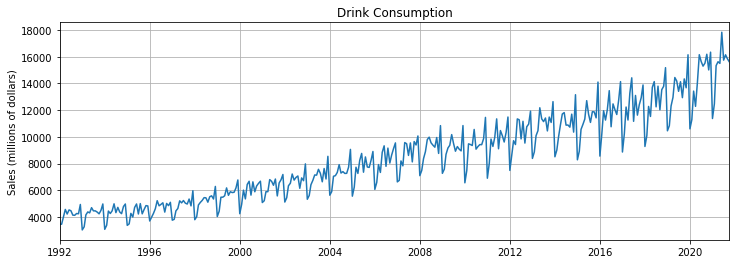

In [ ]:
plt.figure(figsize=(12,4))
plt.title('Drink Consumption')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [ ]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12 # year

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [ ]:
train_set.shape

(346,)

In [ ]:
test_set

array([15009., 16339., 11371., 12473., 15330., 15622., 15499., 17830.,
       15742., 16142., 15840., 15616.])

It's worth noting that in our previous exercise the train and test sets were tensors. Here they're numpy arrays. This is because one of the steps we're about to perform outputs an array, and we'd have to turn it into a tensor anyway.

## Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>
Recall that back in the CNN section we transformed image files using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt><strong>torchvision.transforms.Normalize(<em>mean, std</em>)</strong></tt></a>, both because it was built into DataLoader, and because our pretrained models expected specific normalization values.<br>

Ultimately we want to perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTE: We only want to normalize the training set to avoid data leakage. If we include the test set then the higher average values of the test set could become part of the signal in the training set. 

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted values so that we can compare them to the actual test data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [ ]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [ ]:
train_norm.min()

-1.0

In [ ]:
train_norm.max()

1.0

In [ ]:
train_norm.mean()

-0.2131590248087685

In [ ]:
type(train_norm)

numpy.ndarray

In [ ]:
train_norm.shape

(346, 1)

In [ ]:
train_norm = torch.FloatTensor(train_norm).view(-1)
train_norm.shape

torch.Size([346])

## Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [ ]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

In [ ]:
# Define a window size
window_size = 12

In [ ]:
# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out


In [ ]:
# Apply the input_data function to train_norm
train_data = input_data(train_norm, window_size)
len(train_data)  # this should equal 358-12-12

334

In [ ]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9349, -0.9351, -0.8523, -0.7669, -0.8190, -0.7722, -0.7818, -0.8318,
         -0.8335, -0.8132, -0.8161, -0.7103]),
 tensor([-1.]))

## Define the model
This time we'll use an LSTM layer of size (1,100).

In [ ]:
class LSTMnetwork(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=80,output_size=1):
        super().__init__()
        
        
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

## Instantiate the model, define loss and optimization functions

In [ ]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 80)
  (linear): Linear(in_features=80, out_features=1, bias=True)
)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   320
 25600
   320
   320
    80
     1
______
 26641


## Train the model

In [ ]:
epochs = 80

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.13416900
Epoch:  2 Loss: 0.13112816
Epoch:  3 Loss: 0.07929463
Epoch:  4 Loss: 0.05446699
Epoch:  5 Loss: 0.05503965
Epoch:  6 Loss: 0.04850870
Epoch:  7 Loss: 0.04557842
Epoch:  8 Loss: 0.04074335
Epoch:  9 Loss: 0.03140519
Epoch: 10 Loss: 0.03891478
Epoch: 11 Loss: 0.03001094
Epoch: 12 Loss: 0.01921908
Epoch: 13 Loss: 0.02291710
Epoch: 14 Loss: 0.01080635
Epoch: 15 Loss: 0.00974292
Epoch: 16 Loss: 0.01144488
Epoch: 17 Loss: 0.01534592
Epoch: 18 Loss: 0.03343345
Epoch: 19 Loss: 0.08220920
Epoch: 20 Loss: 0.08803368
Epoch: 21 Loss: 0.02316389
Epoch: 22 Loss: 0.02630955
Epoch: 23 Loss: 0.00663115
Epoch: 24 Loss: 0.07868586
Epoch: 25 Loss: 0.04874282
Epoch: 26 Loss: 0.05864595
Epoch: 27 Loss: 0.03978033
Epoch: 28 Loss: 0.04155522
Epoch: 29 Loss: 0.11245273
Epoch: 30 Loss: 0.04835940
Epoch: 31 Loss: 0.06028200
Epoch: 32 Loss: 0.09278377
Epoch: 33 Loss: 0.09352022
Epoch: 34 Loss: 0.10523451
Epoch: 35 Loss: 0.08738137
Epoch: 36 Loss: 0.07783151
Epoch: 37 Loss: 0.07699651
E

## Run predictions and compare to known test set

In [ ]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [ ]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.9310454726219177,
 0.9932261109352112,
 0.24262501299381256,
 0.5302916765213013,
 0.7094590067863464,
 0.4352572560310364,
 0.8210521936416626,
 0.91214519739151,
 1.0410364866256714,
 1.0541179180145264,
 1.119917631149292,
 1.1644890308380127]

## Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [ ]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[15728.58950523],
       [16137.45829245],
       [11201.88077294],
       [13093.43291897],
       [14271.54769912],
       [12468.53408703],
       [15005.32869929],
       [15604.31074545],
       [16451.83541781],
       [16537.8523699 ],
       [16970.51838362],
       [17263.59762228]])

In [ ]:
df['S4248SM144NCEN'][-12:]

DATE
2020-11-01    15009
2020-12-01    16339
2021-01-01    11371
2021-02-01    12473
2021-03-01    15330
2021-04-01    15622
2021-05-01    15499
2021-06-01    17830
2021-07-01    15742
2021-08-01    16142
2021-09-01    15840
2021-10-01    15616
Name: S4248SM144NCEN, dtype: int64

It looks like our predictions weren't that far off!
## Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [ ]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2020-10-01', '2021-10-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
       '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
       '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
      dtype='datetime64[D]')

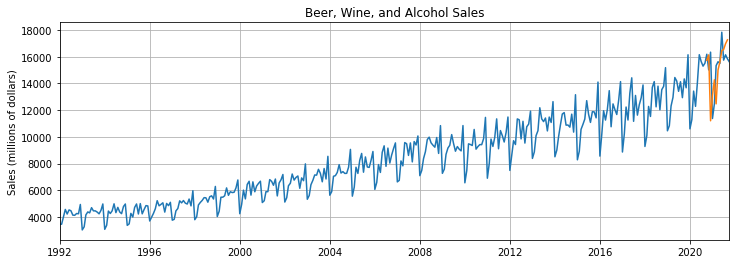

In [ ]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

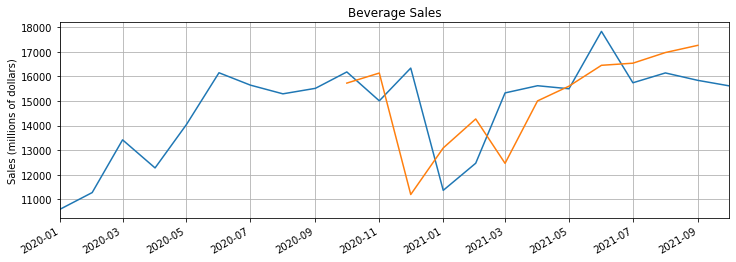

In [ ]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beverage Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2020-01-01':])
plt.plot(x,true_predictions)
plt.show()

For more information on x-axis date formatting in matplotlib, check out <a href='https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.autofmt_xdate'><tt><strong>matplotlib.figure.Figure.autofmt_xdate</strong></tt></a> and <a href='https://matplotlib.org/api/dates_api.html#matplotlib.dates.DateFormatter'><tt><strong>matplotlib.dates.DateFormatter</strong></tt></a>

# Forecast into an unknown future
This time we'll continue training the model using the entire dataset, and predict 12 steps into the future.

In [ ]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.05268021
Epoch:  2 Loss: 0.01348244
Epoch:  3 Loss: 0.00985027
Epoch:  4 Loss: 0.00844938
Epoch:  5 Loss: 0.01315279
Epoch:  6 Loss: 0.00836154
Epoch:  7 Loss: 0.01467874
Epoch:  8 Loss: 0.00350563
Epoch:  9 Loss: 0.00913519
Epoch: 10 Loss: 0.00049872
Epoch: 11 Loss: 0.00000000
Epoch: 12 Loss: 0.00025482
Epoch: 13 Loss: 0.00018023
Epoch: 14 Loss: 0.00634289
Epoch: 15 Loss: 0.00133026
Epoch: 16 Loss: 0.00077691
Epoch: 17 Loss: 0.00000133
Epoch: 18 Loss: 0.00230291
Epoch: 19 Loss: 0.00073300
Epoch: 20 Loss: 0.00385271
Epoch: 21 Loss: 0.00007417
Epoch: 22 Loss: 0.00054881
Epoch: 23 Loss: 0.02342569
Epoch: 24 Loss: 0.00683603
Epoch: 25 Loss: 0.00158435
Epoch: 26 Loss: 0.00109782
Epoch: 27 Loss: 0.00014277
Epoch: 28 Loss: 0.00364738
Epoch: 29 Loss: 0.00085889
Epoch: 30 Loss: 0.00472613
Epoch: 31 Loss: 0.00003259
Epoch: 32 Loss: 0.00000218
Epoch: 33 Loss: 0.00771764
Epoch: 34 Loss: 0.00007060
Epoch: 35 Loss: 0.00029763
Epoch: 36 Loss: 0.00117898
Epoch: 37 Loss: 0.00518594
E

## Predict future values, plot the result

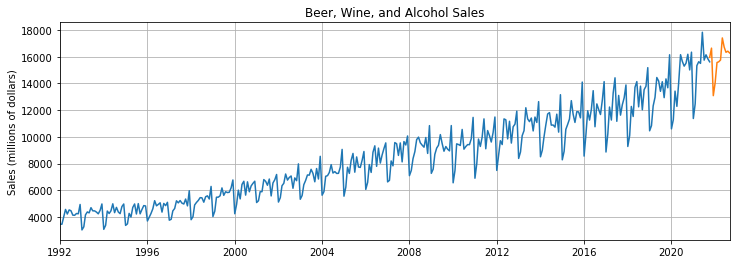

In [ ]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2021-10-01', '2022-10-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

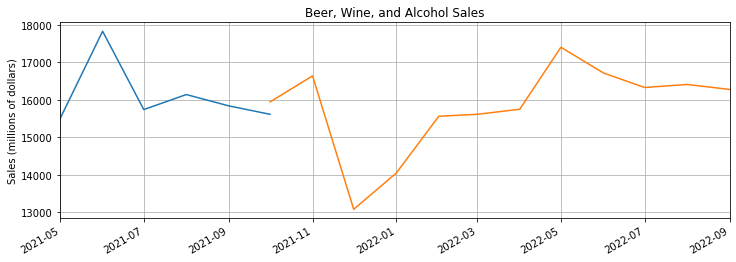

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2021-05-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

<h3>BONUS:</h3>To save time in the future, we've written a function that will take in a time series training data set, and output a tensor of <tt>(seq, label)</tt> tuples.

In [ ]:
# Load dependencies
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler
"""
This has to be done outside the function definition so that
we can inverse_transform the prediction set later on.
"""
scaler = MinMaxScaler(feature_range=(-1, 1))

# Extract values from the source .csv file
df = pd.read_csv('../Data/TimeSeriesData/Alcohol_Sales.csv',index_col=0,parse_dates=True)
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create the training set of values
train_set = y[:-test_size]

In [ ]:
# DEFINE A FUNCTION:
def create_train_data(seq,ws=12):
    """Takes in a training sequence and window size (ws) of
       default size 12, returns a tensor of (seq/label) tuples"""
    seq_norm = scaler.fit_transform(seq.reshape(-1, 1))    
    seq_norm = torch.FloatTensor(seq_norm).view(-1)

    out = []
    L = len(seq_norm)
    for i in range(L-ws):
        window = seq_norm[i:i+ws]
        label = seq_norm[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [ ]:
# Apply the function to train_set
train_data = create_train_data(train_set,12)
len(train_data)  # this should equal 313-12

301

In [ ]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]), tensor([-1.]))

In [ ]:
help(create_train_data)

Help on function create_train_data in module __main__:

create_train_data(seq, ws=12)
    Takes in a training sequence and window size (ws) of
    default size 12, returns a tensor of (seq/label) tuples

